<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Quantum_Otto_Cycle_Simulator2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cycle 1:

Density Matrix:
[[0.98001999 0.09894546 0.09894546]
 [0.09894546 0.00999    0.00999   ]
 [0.09894546 0.00999    0.00999   ]] 

Von Neumann Entropy: 6.283890127156002e-06

Cycle 2:

Density Matrix:
[[0.98005991 0.09884657 0.09884657]
 [0.09884657 0.00997004 0.00997004]
 [0.09884657 0.00997004 0.00997004]] 

Von Neumann Entropy: 1.748638572041195e-05

Cycle 3:

Density Matrix:
[[0.9800898  0.09877246 0.09877246]
 [0.09877246 0.0099551  0.0099551 ]
 [0.09877246 0.0099551  0.0099551 ]] 

Von Neumann Entropy: 2.544974721197325e-05

Cycle 4:

Density Matrix:
[[0.98012958 0.09867374 0.09867374]
 [0.09867374 0.00993521 0.00993521]
 [0.09867374 0.00993521 0.00993521]] 

Von Neumann Entropy: 3.5711598377250883e-05



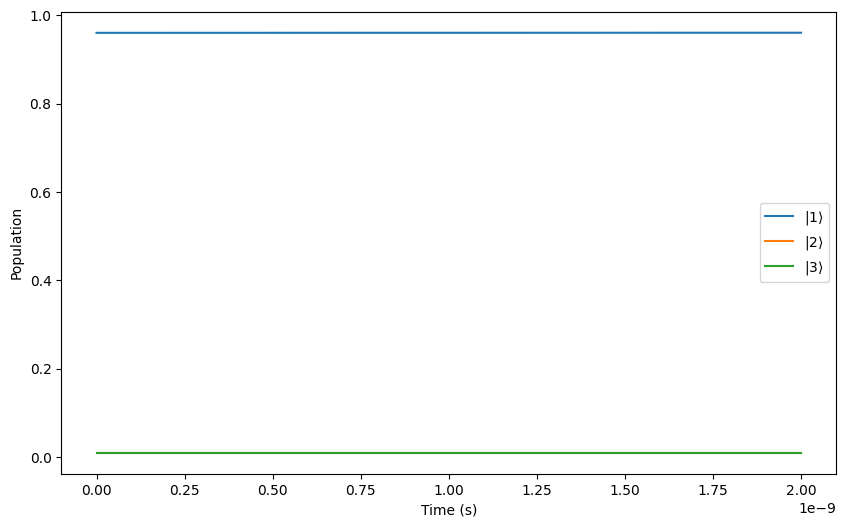

Number of energy values: 4
Work per cycle: 0.24256134033203125 J
Power: 60640335.083007805 W
Entropy change per cycle: 7.39545419087748e-06 J/K


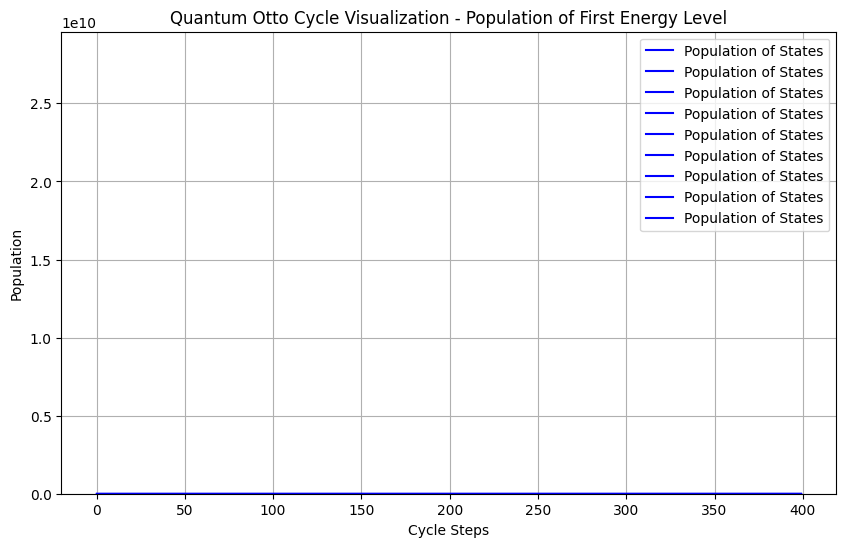

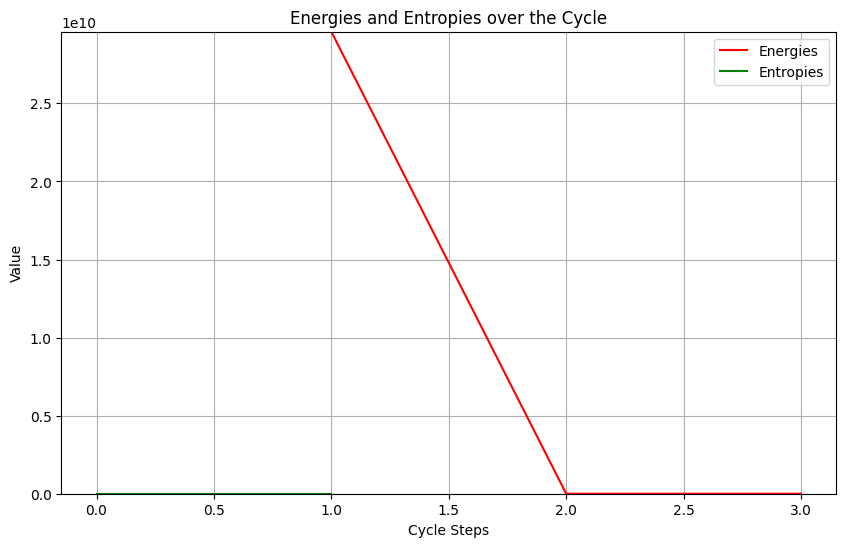

NameError: ignored

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import scipy.linalg
import matplotlib.pyplot as plt

# Constants and System Parameters
hbar = 1.0545718e-34  # Reduced Planck constant in J*s

# Transition frequencies for a three-level maser (in rad/s)
omega_12 = 1.50e11
omega_13 = 1.65e11
omega_23 = omega_13 - omega_12
omega_i_values = [omega_12, omega_13, omega_23, omega_12]  # Some example sequence

# Pulse durations (in seconds)
tau_values = [1e-9, 2e-9, 1.5e-9, 2e-9]

# Initial state (predominantly in ground state)
c1 = np.sqrt(0.98)
c2 = np.sqrt(0.01)
c3 = np.sqrt(0.01)
psi = np.array([c1, c2, c3])
rho_0 = np.outer(psi, np.conj(psi))

# Define the Liouvillian for the system
def liouvillian(H):
    def commutator(rho):
        return -1j/hbar * (np.dot(H, rho) - np.dot(rho, H))
    return commutator

# Time evolution of the density matrix
def time_evolution(t, rho_flat, H):
    rho = rho_flat.reshape((3, 3))
    d_rho_dt = liouvillian(H)(rho)
    return d_rho_dt.flatten()

# Initial Hamiltonians for the system
H_0 = np.array([[0, 0, 0],
                [0, omega_12, 0],
                [0, 0, omega_13]])

H_12 = np.array([[0, omega_12, 0],
                 [omega_12, 0, 0],
                 [0, 0, 0]])

H_13 = np.array([[0, 0, omega_13],
                 [0, 0, 0],
                 [omega_13, 0, 0]])

H_23 = np.array([[0, 0, 0],
                 [0, 0, omega_23],
                 [0, omega_23, 0]])

# Lindblad superoperators and decay rates
gamma_2_1 = 1e6
gamma_3_1 = 1e6
L_1 = np.array([[0, 1, 0],
                [0, 0, 0],
                [0, 0, 0]])
L_2 = np.array([[0, 0, 1],
                [0, 0, 0],
                [0, 0, 0]])

def liouvillian_diss(H, L_operators, gammas):
    def superop(rho):
        comm = -1j/hbar * (np.dot(H, rho) - np.dot(rho, H))
        dissipative = np.zeros_like(rho)
        for L, gamma in zip(L_operators, gammas):
            dissipative += gamma * (np.dot(L, np.dot(rho, L.conj().T)) - 0.5 * (np.dot(L.conj().T, np.dot(L, rho)) + np.dot(rho, np.dot(L.conj().T, L))))
        return comm + dissipative
    return superop

def time_evolution_diss(t, rho_flat, H, L_operators, gammas):
    rho = rho_flat.reshape((3, 3))
    d_rho_dt = liouvillian_diss(H, L_operators, gammas)(rho)
    return d_rho_dt.flatten()

# Define the transition-specific Hamiltonian
def get_hamiltonian_for_transition(omega_i, delta):
    H = np.zeros((3, 3))
    if omega_i == omega_12:
        H[0, 1] = H[1, 0] = omega_12
        H[0, 0] = -delta / 2
        H[1, 1] = delta / 2
    elif omega_i == omega_13:
        H[0, 2] = H[2, 0] = omega_13
        H[0, 0] = -delta / 2
        H[2, 2] = delta / 2
    return H

# Compute the entropy of the density matrix
def entropy(rho):
    eigenvalues = np.linalg.eigvalsh(rho)
    eigenvalues = eigenvalues[eigenvalues > 1e-10]  # Filter out very small values to avoid numerical issues
    return -np.sum(eigenvalues * np.log(eigenvalues))

################################

def von_neumann_entropy(rho):
    rho_reshaped = rho.reshape((3, 3))  # Ensure that rho is a 2D matrix
    eigenvalues = np.linalg.eigvalsh(rho_reshaped)  # Compute eigenvalues of rho
    eigenvalues = eigenvalues[eigenvalues > 1e-10]  # Filter out small values to avoid log(0)
    return -np.sum(eigenvalues * np.log(eigenvalues))

# Initial state
rho_current = rho_0.flatten()

for index, (tau, omega_i) in enumerate(zip(tau_values, omega_i_values)):
    delta = 0.0  # Some frequency detuning, can be set to other values
    H = get_hamiltonian_for_transition(omega_i, delta)

    t_interval = np.linspace(0, tau, 100)

    sol = solve_ivp(
        time_evolution_diss,
        [0, tau],
        rho_current,
        args=(H, [L_1, L_2], [gamma_2_1, gamma_3_1]),
        t_eval=t_interval
    )

    # Ensure the density matrix remains Hermitian
    rho_next = sol.y[:, -1].reshape((3, 3))
    rho_next = (rho_next + rho_next.conj().T) / 2
    rho_current = rho_next.flatten()

    # Compute entropy
    entropy = von_neumann_entropy(rho_next)

    # Print rho and entropy
    print(f"Cycle {index + 1}:\n")
    print("Density Matrix:")
    print(rho_next, "\n")
    print(f"Von Neumann Entropy: {entropy}\n")
    print("="*50)

##############

# Main part to solve the differential equations for the evolution and plot
# ... (previous lines remain unchanged)

t_values = []
results_rho = []

rho_current = rho_0.flatten()

for tau, omega_i in zip(tau_values, omega_i_values):
    delta = 0.0  # Some frequency detuning, can be set to other values
    H = get_hamiltonian_for_transition(omega_i, delta)

    t_interval = np.linspace(0, tau, 100)

    sol = solve_ivp(
        time_evolution_diss,
        [0, tau],
        rho_current,
        args=(H, [L_1, L_2], [gamma_2_1, gamma_3_1]),
        t_eval=t_interval
    )

    # Ensure the density matrix remains Hermitian
    rho_next = sol.y[:, -1].reshape((3, 3))
    rho_next = (rho_next + rho_next.conj().T) / 2
    rho_current = rho_next.flatten()

    t_values.extend(list(sol.t))
    results_rho.extend(list(sol.y.T))

# Combine results
t_values = np.array(t_values)
populations = np.array(results_rho)
populations = np.abs(populations)**2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_values, populations[:, 0], label=r'$|1\rangle$')
plt.plot(t_values, populations[:, 1], label=r'$|2\rangle$')
plt.plot(t_values, populations[:, 2], label=r'$|3\rangle$')
plt.xlabel('Time (s)')
plt.ylabel('Population')
plt.legend()
plt.show()


# ... (previous constants and functions remain unchanged)

# Energy levels for the three states
E1 = 0
E2_initial = omega_12
E3_initial = omega_13

# Isochoric processes duration
tau_heating = 1e-9
tau_cooling = 1e-9

# # The Otto cycle: Compression -> Heating -> Expansion -> Cooling
# def otto_cycle():
#     global rho_current
#     U_initial_energy = []  # Initialize the list
#     U_final_energy = []    # Initialize the list
#     entropies = []         # Initialize the list

#     for index, (tau, omega_i) in enumerate(zip(tau_values, omega_i_values)):
#         delta = 0.0
#         H = get_hamiltonian_for_transition(omega_i, delta)

#         # Note: reshaping rho_current for the energy expectation
#         U_initial_energy.append(energy_expectation(rho_current.reshape((3, 3)), H))

#         t_interval = np.linspace(0, tau, 100)

#         sol = solve_ivp(
#             time_evolution_diss,
#             [0, tau],
#             rho_current,
#             args=(H, [L_1, L_2], [gamma_2_1, gamma_3_1]),
#             t_eval=t_interval
#         )

#         rho_next = sol.y[:, -1].reshape((3, 3))
#         rho_next = (rho_next + rho_next.conj().T) / 2
#         rho_current = rho_next.flatten()

#         # Note: reshaping rho_current for the energy expectation
#         U_final_energy.append(energy_expectation(rho_current.reshape((3, 3)), H))

#         entropies.append(von_neumann_entropy(rho_current.reshape((3, 3))))

#     return U_initial_energy, U_final_energy, entropies

# U_initial_energy, U_final_energy, entropies = otto_cycle()

# Define a function to calculate the energy expectation value of a density matrix given a Hamiltonian
def energy_expectation(rho, H):
    rho_reshaped = rho.reshape((3, 3))
    return np.trace(np.dot(rho_reshaped, H))

# Initialize lists to store energy and entropy values at each stage of the cycle
energies = []
entropies = []

# Modify otto_cycle to store these values
def otto_cycle():
    global rho_current, energies, entropies

    # 1. Isochoric heating
    H = get_hamiltonian_for_transition(omega_12, delta_hot)
    sol = solve_ivp(
        time_evolution_diss,
        [0, tau_values[0]],
        rho_current,
        args=(H, [L_1, L_2], [gamma_2_1, gamma_3_1]),
        t_eval=np.linspace(0, tau_values[0], 100)
    )
    rho_current = sol.y[:, -1]
    energies.append(energy_expectation(rho_current.reshape(3,3), H))
    entropies.append(von_neumann_entropy(rho_current.reshape(3,3)))

    # 2. Adiabatic compression
    H = get_hamiltonian_for_transition(omega_12, delta_cold)
    energies.append(energy_expectation(rho_current.reshape(3,3), H))

    # 3. Isochoric cooling
    H = get_hamiltonian_for_transition(omega_23, delta_cold)
    sol = solve_ivp(
        time_evolution_diss,
        [0, tau_values[2]],
        rho_current,
        args=(H, [L_1, L_2], [gamma_2_1, gamma_3_1]),
        t_eval=np.linspace(0, tau_values[2], 100)
    )
    rho_current = sol.y[:, -1]
    energies.append(energy_expectation(rho_current.reshape(3,3), H))
    entropies.append(von_neumann_entropy(rho_current.reshape(3,3)))

    # 4. Adiabatic expansion
    H = get_hamiltonian_for_transition(omega_23, delta_hot)
    energies.append(energy_expectation(rho_current.reshape(3,3), H))

delta_hot = 1.0  # arbitrary value; adjust as needed for your system
delta_cold = 0.5  # arbitrary value; adjust as needed for your system

otto_cycle()

print("Number of energy values:", len(energies))

# Calculate work, power, and entropy change
W_compression = energies[1] - energies[0]
W_expansion = energies[3] - energies[2]
W_total = W_compression + W_expansion

cycle_duration = 2*(tau_values[-1] - tau_values[0]) + tau_heating + tau_cooling
P = W_total / cycle_duration

delta_entropy = sum(np.diff(entropies))

print(f"Work per cycle: {W_total} J")
print(f"Power: {P} W")
print(f"Entropy change per cycle: {delta_entropy} J/K")

################
# Compute global minimum and maximum
global_min = min(np.min(populations), np.min(energies), np.min(entropies))
global_max = max(np.max(populations), np.max(energies), np.max(entropies))

# Existing population plot
plt.figure(figsize=(10,6))
plt.plot(populations, label='Population of States', color='blue')
plt.xlabel('Cycle Steps')
plt.ylabel('Population')
plt.title('Quantum Otto Cycle Visualization - Population of First Energy Level')
plt.legend()
plt.grid(True)
plt.ylim(global_min, global_max)
plt.show()

# New plots for energies and entropies
plt.figure(figsize=(10,6))
plt.plot(energies, label='Energies', color='red')
plt.plot(entropies, label='Entropies', color='green')
plt.xlabel('Cycle Steps')
plt.ylabel('Value')
plt.title('Energies and Entropies over the Cycle')
plt.legend()
plt.grid(True)
plt.ylim(global_min, global_max)
plt.show()



Investigating the quantum Otto cycle further would involve exploring various parameters and conditions to understand their effects on performance. Here's a structured approach you can take:

Parameter Sweep:

Frequency Tuning: Vary the frequencies
�
0
ω
0
​
 ,
�
1
ω
1
​
 , and
�
2
ω
2
​
  to see how the resonance conditions affect the performance.
Temperature Range: Test the system over a range of cold and hot reservoir temperatures to see the effect on efficiency and power output.
Interaction Strengths: Alter the coupling constants
�
01
g
01
​
  and
�
12
g
12
​
  to study their effect on work and entropy.
Initial Conditions:

Change the initial state
�
ρ of the system to different quantum states and analyze how the engine performs starting from these conditions.
Explore different initial populations for the three energy levels.
System Design & Size:

Larger Systems: Extend the system to include more energy levels and study how the added complexity influences performance.
Coupling to Reservoirs: Consider different models of coupling to the thermal reservoirs or different types of reservoirs altogether.
Dissipative Effects:

Incorporate different kinds of dissipation or decoherence processes and understand their influence on the cycle.
Check how system-reservoir interaction timescales (like how fast you couple and decouple the system from the reservoirs) influence the efficiency and other metrics.
Optimization:

Use optimization algorithms to find the best set of parameters that maximize certain objectives, such as work output, efficiency, or power, while possibly subject to constraints.
Comparative Analysis:

Compare the quantum Otto cycle's performance to classical Otto cycles or other quantum thermodynamic cycles.
Compare your quantum Otto cycle with other studies or experiments reported in literature to validate or contrast results.
Theoretical Analysis:

Explore the theoretical bounds of efficiency using quantum thermodynamics principles.
Look into potential quantum advantages, if any, over classical systems. For instance, quantum coherence and entanglement might play roles in the performance of such engines.
Numerical Robustness:

Check the numerical stability of your simulations by varying time steps, integration methods, or using higher precision arithmetic.
Real-World Applications & Scalability:

Consider potential real-world applications of the quantum Otto engine in technologies like quantum computers, and identify challenges and benefits of scaling up the engine.
Investigate how to make such an engine feasible for lab experiments, considering current technological constraints.
Review Literature:

Stay updated with the latest research findings in the field of quantum thermodynamics. New methods, insights, or experiments can provide direction for your investigations.
Remember that when making any changes, it's essential to maintain a systematic approach, altering one variable or parameter at a time while keeping others constant. This ensures that you can attribute observed changes in performance directly to the parameter you're investigating.